In [2]:
import numpy as np
from astropy.table import Table
import fitsio
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.units import Unit, deg
# import esutil.htm

from kl_tools.utils import get_base_dir

plt.rcParams['figure.facecolor'] = 'white'

## Load catalog

In [3]:
data_dir = get_base_dir() / 'data/kross'
kross_file = data_dir / 'kross_release_v2.fits'
kross = Table.read(kross_file)
print(kross)
print()
print('columns:')
for col in kross.columns:
    print(col)

KID          NAME              RA    ...     Q_g_ERR_HIGH        Q_g_ERR_LOW    
--- ---------------------- --------- ... ------------------- -------------------
  5 C-HiZ_z1_111           149.91857 ...  1.7512620354551027   1.646517934263986
  6 C-HiZ_z1_112           149.92027 ... 0.10000000149011612 0.10000000149011612
 11 C-HiZ_z1_186           150.13445 ... 0.10673877161940218 0.09454050762550496
 13 C-HiZ_z1_195           150.14436 ... 0.28722910384594535 0.23534917318750898
 14 C-HiZ_z1_215           150.19725 ...  2.6589545923456943  0.9011844851922549
 15 C-HiZ_z1_224           150.21813 ...  0.6775202513409566  0.6254703901918698
 16 C-HiZ_z1_230           150.22743 ... 0.31336535207531546  0.2770292860371245
 17 C-HiZ_z1_231           150.22769 ... 0.08354552575839605 0.06903268467132428
 18 C-HiZ_z1_235           150.23394 ...  0.8794488319675884  0.6004005762938587
 20 C-HiZ_z1_245           150.25717 ...  1.1891689436891653  1.1201204575463677
...                    ...  

## Make sample selection

Text(0.5, 0, 'Kinematic Type')

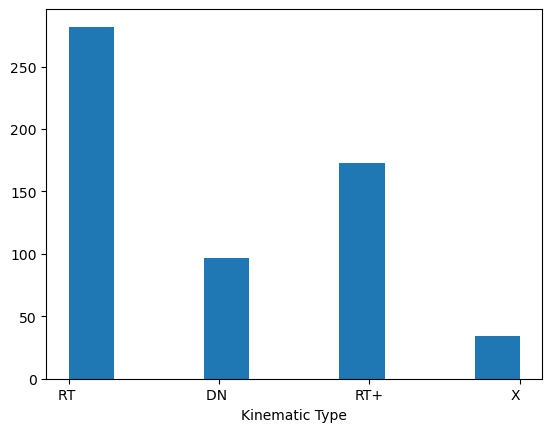

In [4]:
plt.hist(kross['KIN_TYPE'])
plt.xlabel('Kinematic Type')

In [5]:
vc = kross['VC'] # The corrected "intrinsic" circular velocity **NOTE** already has inclination correction, plus beam smearing
sigma = kross['SIGMA_TOT'] # velocity dispersion from aperture spectrum
theta_im = kross['THETA_IM'] # TThe inferred inclination angle, θim, with error. If θim < 25 then excluded from the analyses.
theta_flag = kross['THETA_FLAG'] # If =1 then the inclination angle was fixed to 53o ± 18.
quality = kross['QUALITY_FLAG'] # Quality 1: Hα detected, spatially-resolved and both θim and R1/2 were measured from the broad-band
# Quality 2: Hα detected and spatially resolved but θim was fixed (see THETA_FLAG) and/or R1/2 was estimated from the kinematic (see R_FLAG)
# Quality 3: Hα detected and resolved in the IFU data but only an upper limit on R1/2
# Quality 4: Hα detected but unresolved in the IFU data.
agn_flag = kross['AGN_FLAG'] # If =1 AGN emission affecting the emission-line properties and are excluded from the final analyses.
irr_flag = kross['IRR_FLAG'] # If =1 unphysical measurements for the rotational velocities and/or the half-light radii and are excluded from the final analyses
extrap_flag = kross['EXTRAP_FLAG'] # If =1, vC extrapolated >2 pixels beyond the extent of the data, if =2 then vC was estimated by scaling σtot
kin_type = kross['KIN_TYPE'] # Kinematic classification: RT+ “gold” rotationally dominated; RT: rotationally dominated; DN: dispersion dominated; X: IFU data is spatially unresolved;

selection = np.where(
    ((vc / sigma) > 1) &
    (quality == 1) &
    (agn_flag == 0) &
    (irr_flag == 0) &
    (theta_flag == 0) &
    (extrap_flag == 0) &
    # (kin_type == 'RT+')
    ((kin_type == 'RT ') | (kin_type == 'RT+'))
)

# for *no* selection:
# selection = np.arange(0, len(kross))

Nkross = len(kross)
sample = kross[selection]
Nsample = len(sample)

print(f'sample before selection: {Nkross}')
print(f'sample after selection: {Nsample}')

# update cols with selection
vc = vc[selection]
sigma = sigma[selection]
theta_im = theta_im[selection]
theta_flag = theta_flag[selection]
quality = quality[selection]
agn_flag = agn_flag[selection]
irr_flag = irr_flag[selection]
extrap_flag = extrap_flag[selection]
kin_type = kin_type[selection]

# get more useful columns
ra = sample['RA']
dec = sample['DEC']
z = sample['Z']
vc_err_h = sample['VC_ERR_H']
vc_err_l = sample['VC_ERR_L']
n = sample['VDW12_N'] # sersic index
boa = sample['B_O_A'] # The observed axis ratio b/a from the broad-band image
rmag = sample['R_AB']
mstar = sample['MASS']
pa_im = sample['PA_IM']
name = sample['NAME']

# derived columns
log_mstar = np.log10(mstar)
vcirc = vc * np.sin(np.deg2rad(theta_im)) # "observed" vcirc with beam smearing correction but *NOT* inclination correction
vcirc_err = (vc_err_h - vc_err_l) * np.sin(np.deg2rad(theta_im)) # estimated error on 2D vcirc
eobs = (1. - np.sqrt(1. - boa**2)) / (1. + np.sqrt(1. - boa**2))

sample before selection: 586
sample after selection: 243


## Estimate Tully-Fisher velocity vtf

## Tully-Fisher

We use the following table from [Bell et al. 2001](https://ui.adsabs.harvard.edu/abs/2001ApJ...550..212B/abstract):

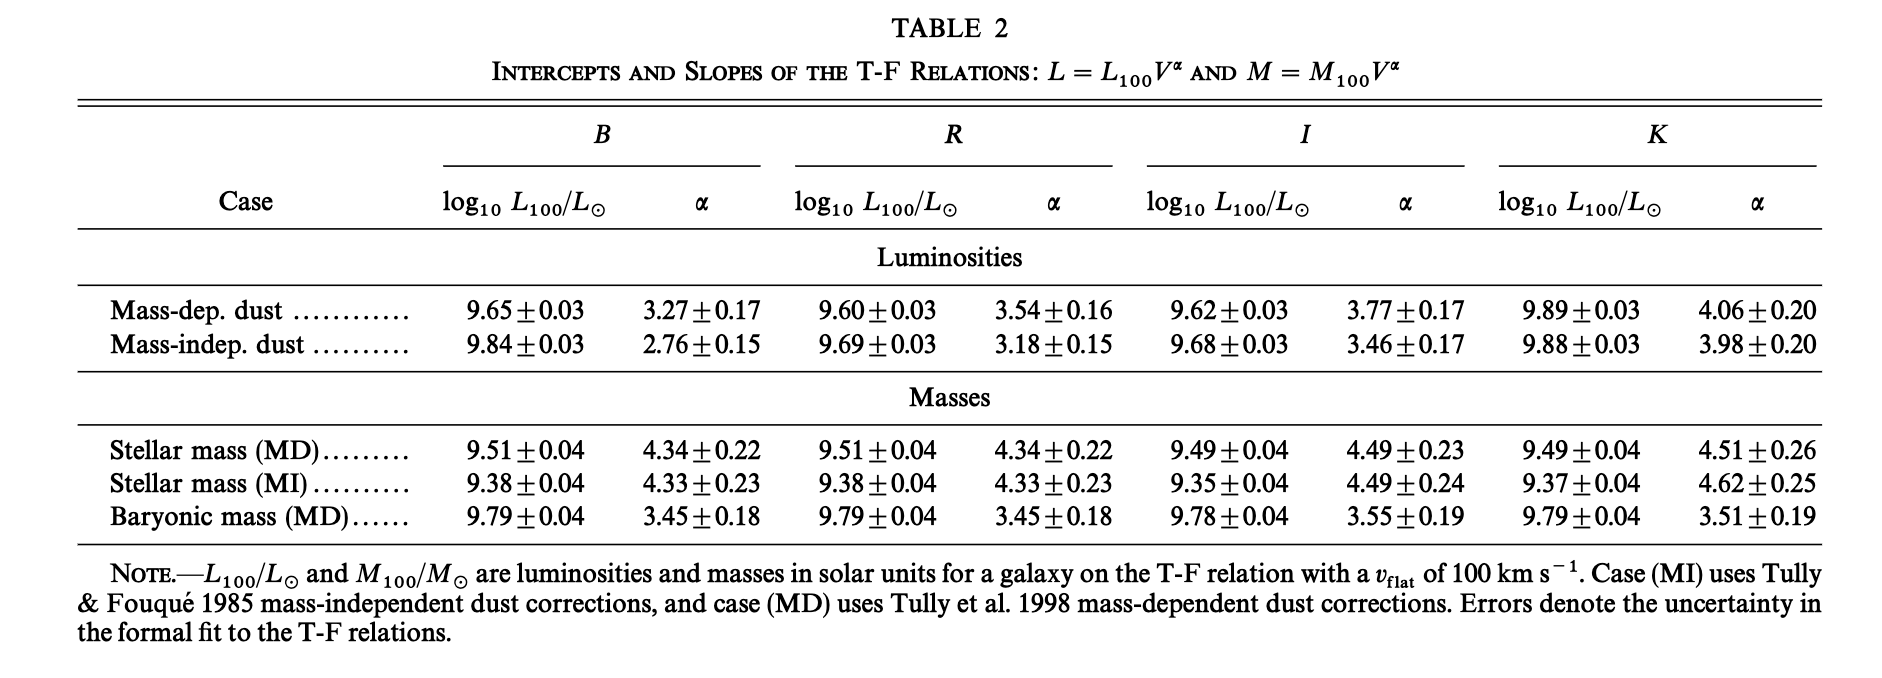

The stellar masses are determined using $H$-band, so we use $K$-band (closest) values for $M=M_{100}V^\alpha$. Note that most band coefficients are extremely consistent with one another for MD

In [6]:
def estimate_vtf(log_mstar, alpha=4.51, log_M100=9.49):
    '''
    Values are for K-band. Logs are base 10
    '''
    log_vtf = (1. / alpha) * (log_mstar - log_M100)
#     print(10**log_vtf)
    return 100*10**log_vtf

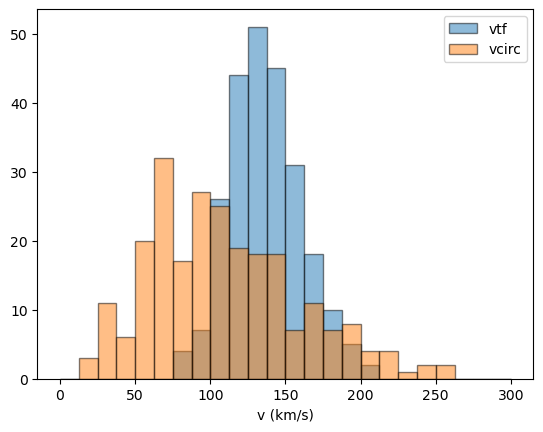

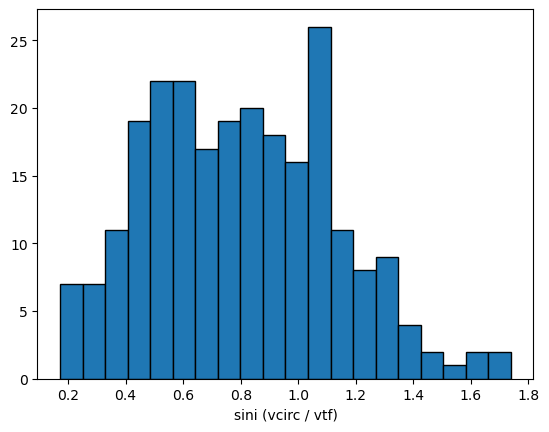

In [7]:
vtf = estimate_vtf(log_mstar)

bins = np.linspace(0, 300, 25)
plt.hist(vtf, ec='k', bins=bins, label='vtf', alpha=0.5)
plt.hist(vcirc, ec='k', bins=bins, label='vcirc', alpha=0.5)
plt.legend()
plt.xlabel('v (km/s)')
plt.show()

sini = vcirc / vtf
plt.hist(sini, ec='k', bins=20)
plt.xlabel('sini (vcirc / vtf)')
plt.show()

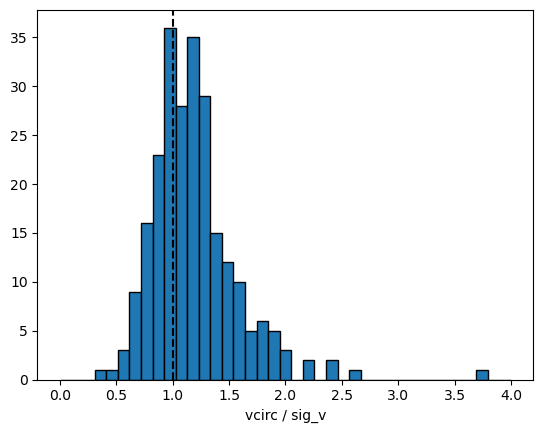

Text(0.5, 0, 'vc / sig_v)')

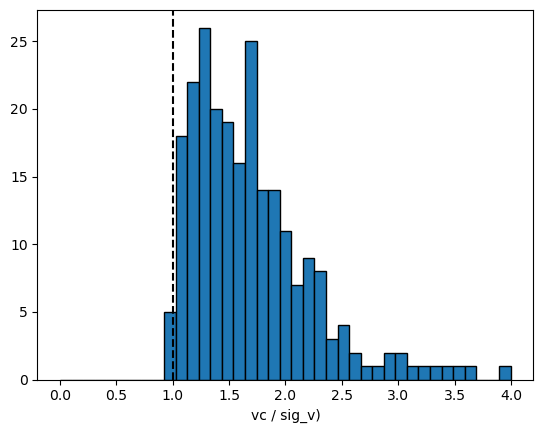

In [8]:
bins = np.linspace(0, 4, 40)
plt.hist(vcirc / sigma, bins=bins, ec='k')
plt.axvline(1, c='k', ls='--')
plt.xlabel('vcirc / sig_v')
plt.show()
plt.hist(vc / sigma, bins=bins, ec='k')
plt.axvline(1, c='k', ls='--')
plt.xlabel('vc / sig_v)')

## Estimate shear

In [9]:
# OLD WAY:
def estimate_sini_old(vmax, vtf):
    return vmax / vtf

from kl_tools.kross.analytic_estimators import estimate_sini_from_vtf_single

def estimate_eint(sini, qz=0.25):
    factor = np.sqrt(1 - (1-qz)**2 * sini**2)
    eint = (1 - factor) / (1 + factor)
    return eint

def estimate_gplus(eobs, eint):
    gplus = (eobs**2 - eint**2) / (2 * eobs * (1-eint**2))
    return gplus

def estimate_gcross(vmax, vmin, eobs, eint, sini):
    cosi = np.sqrt(1 - sini**2)
    gcross = abs(vmin / vmax) * (2 * eint) / (cosi * (2*eint + 1 + eobs**2))
    return gcross

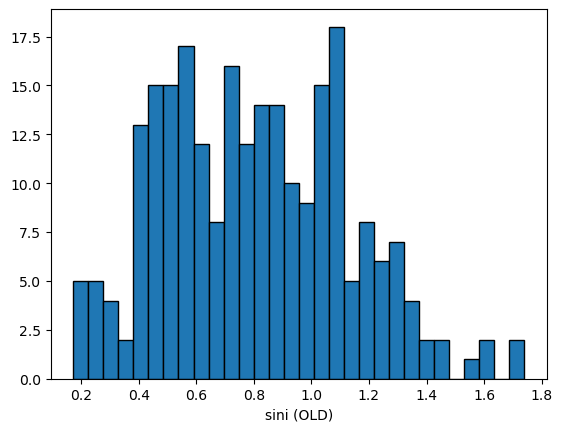

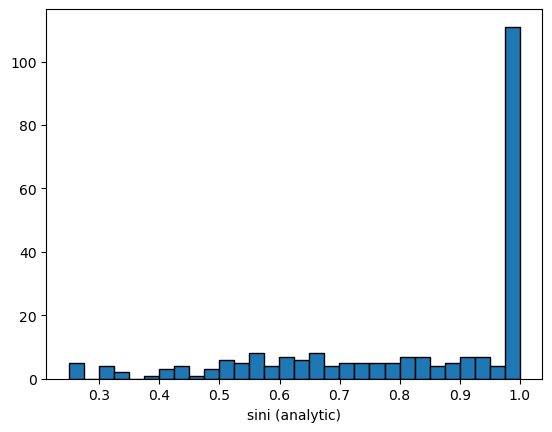

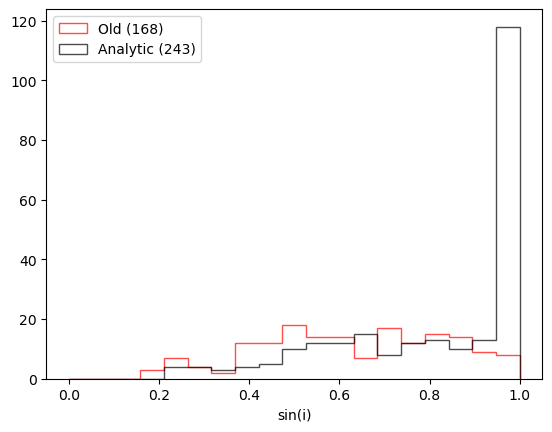

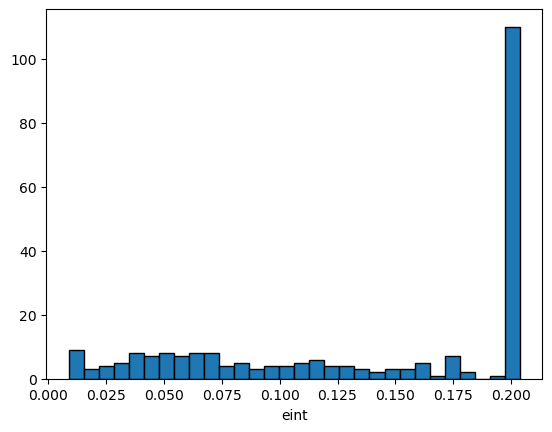

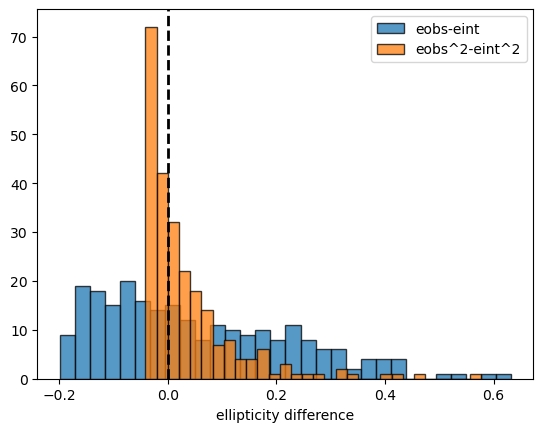

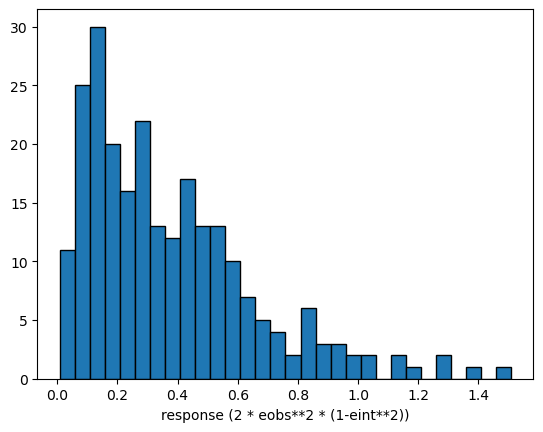

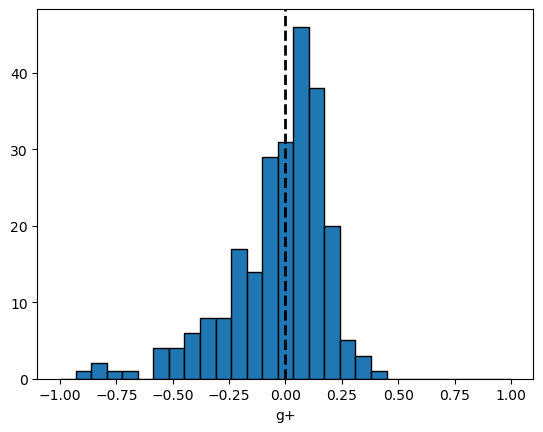

In [12]:
# plotting options
Nbins = 30

# estimate sini from vcirc and TF velocity (OLD):
sini_old = estimate_sini_old(vcirc, vtf)
plt.hist(sini_old, bins=Nbins, ec='k')
plt.xlabel('sini (OLD)')
plt.show()

sini = -1. * np.ones(len(vcirc))
for i in range(len(vcirc)):
    sini[i] = estimate_sini_from_vtf_single(vcirc[i], vtf[i], vcirc_err[i])
plt.hist(sini, bins=Nbins, ec='k')
plt.xlabel('sini (analytic)')
plt.show()

# compare the two sini methods
Nold = len(sini_old[sini_old <= 1])
Nnew = len(sini)
plt.hist(sini_old, ec='r', histtype='step', alpha=0.7, bins=np.linspace(0, 1, 20), label=f'Old ({Nold})')
plt.hist(sini, ec='k', histtype='step', alpha=0.7, bins=np.linspace(0, 1, 20), label=f'Analytic ({Nnew})')
plt.xlabel('sin(i)')
plt.legend()
plt.show()

# estimate intrinsic ellipticity from sini and qz (assumed):
eint = estimate_eint(sini)
plt.hist(eint, bins=Nbins, ec='k')
plt.xlabel('eint')
plt.show()

# look at difference in eobs vs estimated eint
edelt = eobs - eint
edelt2 = eobs**2-eint**2
plt.hist(edelt, bins=Nbins, ec='k', label='eobs-eint', alpha=0.75)
plt.hist(edelt2, bins=Nbins, ec='k', label='eobs^2-eint^2', alpha=0.75)
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('ellipticity difference')
plt.legend()
plt.show()

# show shear response
response = (2 * eobs * (1-eint**2))
plt.hist(response, bins=Nbins, ec='k')
plt.xlabel('response (2 * eobs**2 * (1-eint**2))')
plt.show()

# estimate shear values from estimated eint:
gplus = estimate_gplus(eobs, eint)
plt.hist(gplus, bins=np.linspace(-1, 1, Nbins), ec='k')
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('g+')
# plt.xlim(-1, 1)
plt.show()

# gcross = estimate_gcross(vcirc, vmin, eobs, eint, sini)
# plt.hist(gcross, bins=Nbins, ec='k')
# plt.xlabel('gx')

2.011228


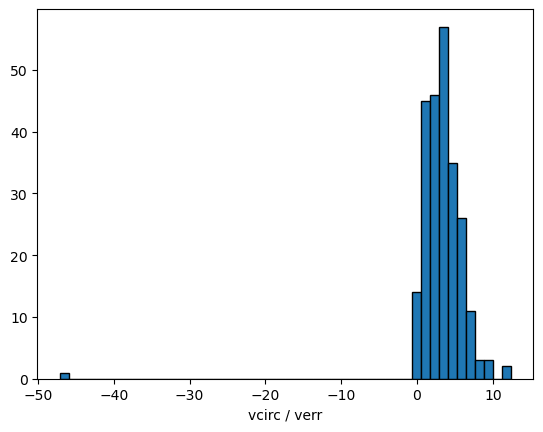

In [27]:
verr = vc_err_h - vc_err_l
s2n = vcirc / verr
plt.hist(s2n, ec='k', bins=50)
plt.xlabel('vcirc / verr')
print(min(vc_err_l))
# plt.xlim(0, 10)

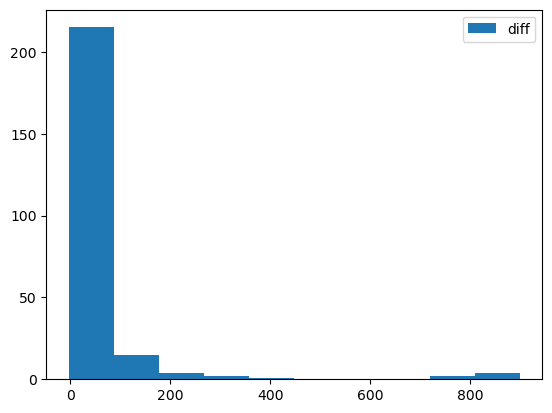

In [28]:
plt.hist(vc_err_h-vc_err_l, label='diff')
plt.legend()

(-1.0, 1.0)

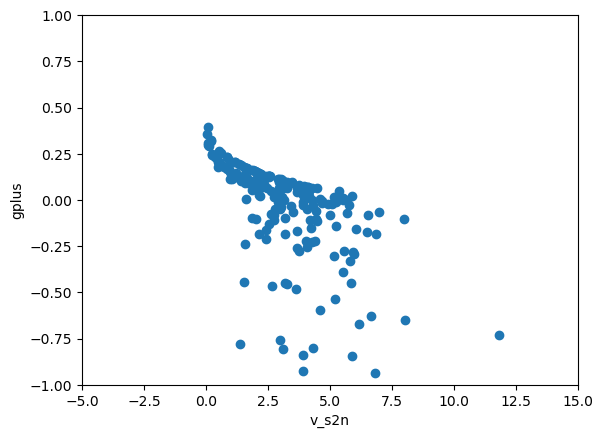

In [29]:
plt.scatter(s2n, gplus)
plt.xlabel('v_s2n')
plt.ylabel('gplus')
plt.xlim(-5, 15)
plt.ylim(-1, 1)

In [30]:
ind = np.where(
    (1 < dec) & 
    (3 > dec) &
    (149 < ra) &
    (152 > ra) &
    (gplus < -1)
)[0][1]
print(gplus[ind])
print(f'{float(ra[ind]):.6f}, {float(dec[ind]):.6f}')

from astropy.coordinates import SkyCoord
from astropy.units import Unit, deg
coord = SkyCoord(ra=ra[ind]*deg, dec=dec[ind]*deg)
print(coord)

-1.5939079560832219
150.410560, 2.079824
<SkyCoord (ICRS): (ra, dec) in deg
    (150.41056, 2.0798239)>


## Field split analysis

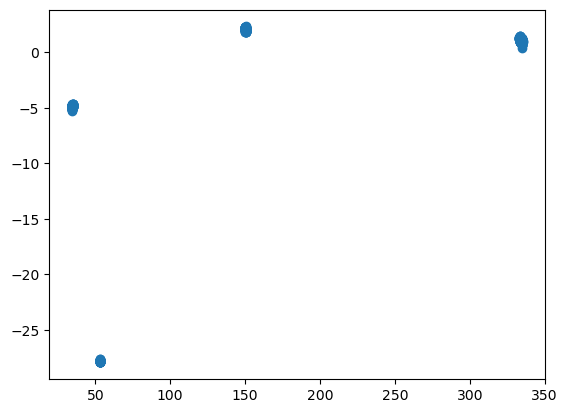

In [31]:
plt.scatter(ra, dec)

(array([63.,  0.,  0.,  0.,  0.,  0., 52.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 74.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 54.]),
 array([ 34.188342  ,  37.19863568,  40.20892936,  43.21922304,
         46.22951672,  49.2398104 ,  52.25010408,  55.26039776,
         58.27069144,  61.28098512,  64.2912788 ,  67.30157248,
         70.31186616,  73.32215984,  76.33245352,  79.3427472 ,
         82.35304088,  85.36333456,  88.37362824,  91.38392192,
         94.3942156 ,  97.40450928, 100.41480296, 103.42509664,
        106.43539032, 109.445684  , 112.45597768, 

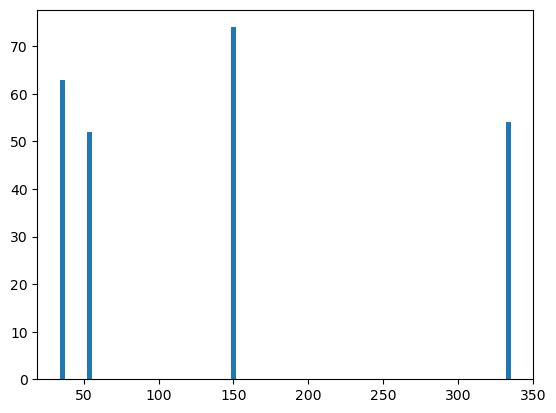

In [17]:
plt.hist(ra, bins=100)

In [18]:
field1 = np.where(
    (ra > 32) & (ra < 37)
)

field2 = np.where(
    (ra > 49) & (ra < 56)
)

# COSMOS
field3 = np.where(
    (ra > 147) & (ra < 153)
)

field4 = np.where(
    (ra > 332) & (ra < 337)
)

Nfield1 = len(sample[field1])
Nfield2 = len(sample[field2])
Nfield3 = len(sample[field3])
Nfield4 = len(sample[field4])

Nfields = Nfield1 + Nfield2 + Nfield3 + Nfield4

print('Nsample:',Nsample)
print('Nfield1:',Nfield1)
print('Nfield2:',Nfield2)
print('Nfield3:',Nfield3)
print('Nfield4:',Nfield4)
print('Nfields:',Nfields)

assert Nsample == Nfields

Nsample: 243
Nfield1: 63
Nfield2: 52
Nfield3: 74
Nfield4: 54
Nfields: 243


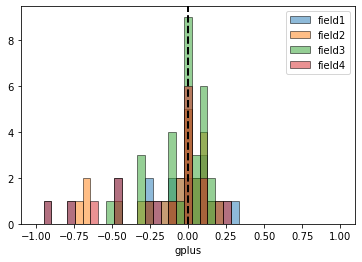

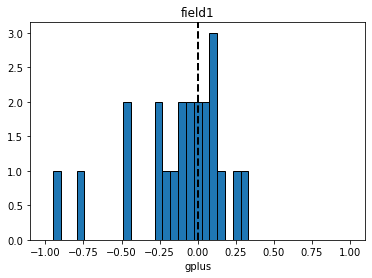

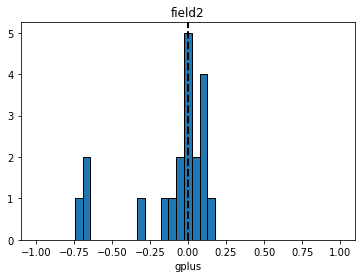

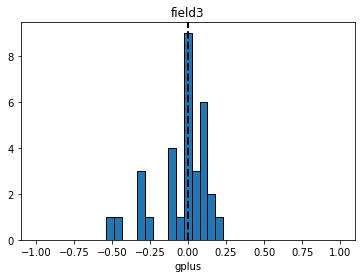

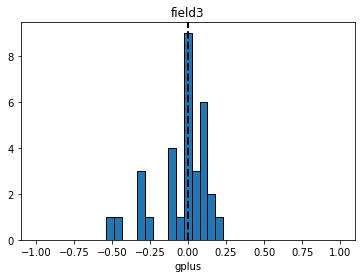

In [17]:
gp_field1 = gplus[field1]
gp_field2 = gplus[field2]
gp_field3 = gplus[field3]
gp_field4 = gplus[field4]

bins = np.linspace(-1, 1, 40)
alpha = 0.5
plt.hist(gp_field1, bins=bins, ec='k', alpha=alpha, label='field1')
plt.hist(gp_field2, bins=bins, ec='k', alpha=alpha, label='field2')
plt.hist(gp_field3, bins=bins, ec='k', alpha=alpha, label='field3')
plt.hist(gp_field4, bins=bins, ec='k', alpha=alpha, label='field4')
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('gplus')
plt.legend()
plt.show()

plt.hist(gp_field1, bins=bins, ec='k')
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('gplus')
plt.title('field1')
plt.show()

plt.hist(gp_field2, bins=bins, ec='k')
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('gplus')
plt.title('field2')
plt.show()

plt.hist(gp_field3, bins=bins, ec='k')
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('gplus')
plt.title('field3')
plt.show()

plt.hist(gp_field3, bins=bins, ec='k')
plt.axvline(0, c='k', ls='--', lw=2)
plt.xlabel('gplus')
plt.title('field3')
plt.show()

## COSMOS field

In [19]:
f3_ra = ra[field3]
f3_dec = dec[field3]
f3_gplus = gplus[field3]
f3_pa_im = pa_im[field3]
f3_name = name[field3]

# TODO: Add kid here (might need to load from sample in cell 2-3)

t = Table()
t['ra'] = f3_ra
t['dec'] = f3_dec
t['gplus'] = f3_gplus
t['pa_im'] = f3_pa_im
t['name'] = f3_name

# now match to Leauthaud et al. 2007
cosmos = Table.read('./cosmosACS_sourcecatalog_2018.fits')

from astropy.coordinates import SkyCoord, match_coordinates_sky

kross_coords  = SkyCoord(ra=f3_ra*deg, dec=f3_dec*deg)
cosmos_coords = SkyCoord(ra=cosmos['RA']*deg, dec=cosmos['DEC']*deg)
idx, d2d, d3d = match_coordinates_sky(kross_coords, cosmos_coords)

print(f'found {len(idx)} matches of {len(t)}')
assert len(idx) == len(t)

# g1 = cosmos['gamma1'][idx]
# g2 = cosmos['gamma2'][idx]

# t['cosmos_g1'] = g1
# t['cosmos_g2'] = g2

# depth = 12
# match_radius = 1. / 3600
# # h = htm.HTM(depth)

# matcher = htm.Matcher(
#     depth=depth,
#     ra=cosmos['RA'],
#     dec=cosmos['DEC']
# )

# id_kross, id_cos, dist = matcher.match(
#     ra=f3_ra,
#     dec=f3_dec,
#     radius=match_radius
# )


t.write('./shear_estimates.fits', overwrite=True)

found 40 matches of 40


In [ ]:
f3_pa_im

In [ ]:
# plt.scatter(t['gplus'], t['cosmos_g1'])
# plt.xlabel('kross gplus')
# plt.ylabel('cosmos g1')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.plot([-1, 1], [-1, 1], ls='--', c='k', lw=2)
# plt.show()

# bins = np.linspace(-1, 1, 50)
# plt.hist(t['gplus'], bins=bins, ec='k', alpha=0.6, label='kross gplus')
# plt.hist(t['cosmos_g1'], bins=bins, ec='k', alpha=0.6, label='cosmos_g1')
# plt.xlabel('g1')
# plt.legend()
# plt.show()

In [ ]:
field3_sample = sample[field3]

for obj in field3_sample:
    obj_ra = obj['RA']
    obj_dec = obj['DEC']
    coord = SkyCoord(ra=obj_ra*deg, dec=obj_dec*deg)
#     print(coord)

In [ ]:
cosmos = Table.read('./COSMOS_ACS_catalog/acs_clean.fits')

In [ ]:
for col in cosmos.columns:
    print(col)

In [ ]:
import fitsio

im = fitsio.read('COSMOS_ACS_catalog/Maps/density_20_25.fits')
plt.imshow(im, origin='lower')
plt.colorbar()

In [ ]:
plt.hist(cosmos['gamma1'], bins=10000)

In [ ]:
plt.hist(kross['Z'], ec='k', bins=20)
plt.xlabel('z')

In [ ]:
kross['PA_IM']